In [1]:
import numpy as np
import pandas as pd # we need pandas to manipulate time series
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

import pastas as ps
import os
import folium

## Mediterranean Climate with a hot summer

This Meditteranean Climate can be found on the South-West Coast of the USA, in California. This climate is characterized by a mild and rainy winters with hot and sunny summers. The average winter temperatures are around 8 degrees celcius, where the summer temperatures are on average 25 degrees celcius. Most of the rain falls from November to March. Snowfall is rare in the area. 

This well is situated near Sacremento in California on a height of 38.1 meters. The well is part of the Central Valley aquifer system and it is classified as an confined aquifer. The water in the well is between 38 and 51 meters below the ground surface. The lithology of the first 75 meters is described as sandy. 


The groundwater data was taken from the USGS website: https://maps.waterdata.usgs.gov/mapper/ \
The Precipitation and Temperature data was taken from the NCEI NOAA website: https://www.ncei.noaa.gov/maps/daily-summaries/ \
Using the Temperature data, the Evaporation was generated with the help of the pyet python package, using the Hargreaves formula. 

In [2]:
map = folium.Map(location=[38.41, -121.21], zoom_start=6)
folium.Marker([38.55, -121.42], popup='Weather Station').add_to(map)
folium.Marker([38.41, -121.21], popup='Well').add_to(map);

In [3]:
map

### Importing Data

#### Sacremento, Well 382444121123301
#### Groundwater series

In [4]:
height = 38.1 # meters above mean sea level

head_import = pd.read_csv('GW_Data/Sacramento_382444121123301.csv', delimiter=';', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(head_import.index)
head_old = head_import.sort_index()

head = -head_old.subtract(height)  # Water level above MSL

In [5]:
head 

Date and Time
1987-01-10    -0.423672
1987-08-22    -2.200656
1987-09-05    -2.346960
1987-09-19    -2.234184
1987-09-26    -2.441448
                ...    
2024-09-27   -12.954000
2024-10-04   -12.911328
2024-10-15   -12.990576
2024-10-18   -12.926568
2024-10-25   -13.149072
Name: Value, Length: 1808, dtype: float64

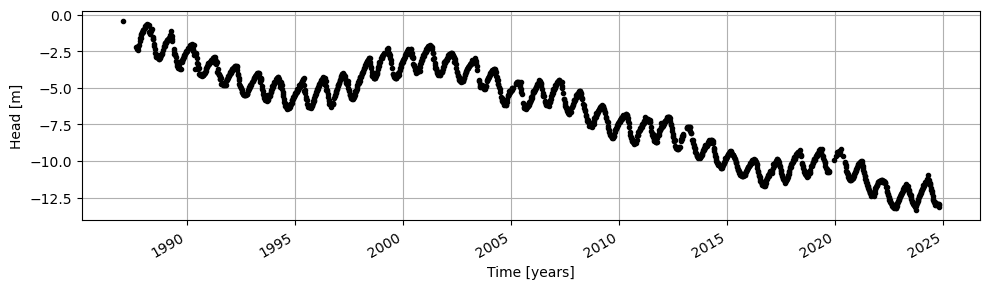

In [6]:
head.plot(linestyle="", marker=".", color="k", figsize=(10, 3))
plt.ylabel('Head [m]')
plt.xlabel('Time [years]')
plt.grid();

#### Precipitation

In [7]:
prec = pd.read_csv('Prec_temp/Sacremento_4008640.csv', delimiter=',', index_col=0, skiprows=0, usecols=[5, 10], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(prec.index)
PRCP = prec.sort_index()

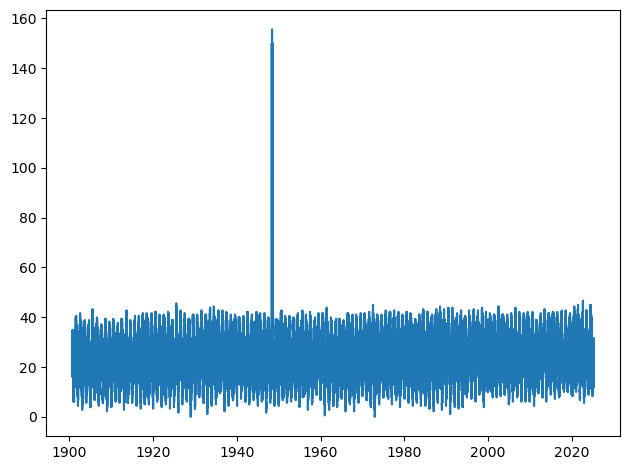

In [8]:
plt.plot(PRCP);

Getting rid of outliers

In [9]:
PRCP = pd.Series(np.where(PRCP > 60, np.nan, PRCP), index=PRCP.index)

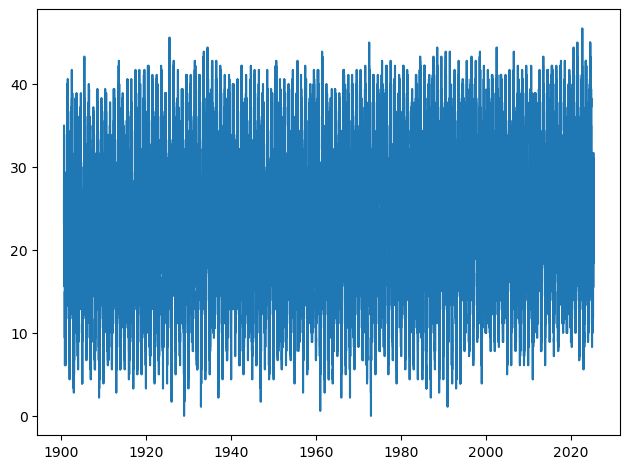

In [10]:
plt.plot(PRCP);

#### Evaporation

In [11]:
evap = pd.read_csv('Evap/Sacremento.csv', delimiter=',', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(evap.index)
EPOT = evap.sort_index()

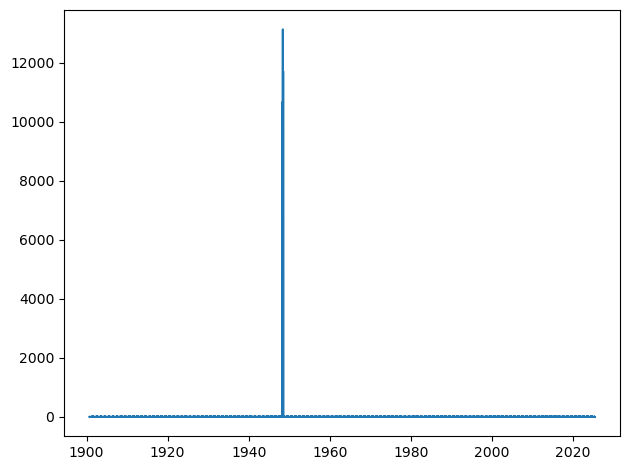

In [12]:
plt.plot(EPOT);

In [13]:
EPOT = pd.Series(np.where(EPOT > 50, np.nan, EPOT), index=EPOT.index)

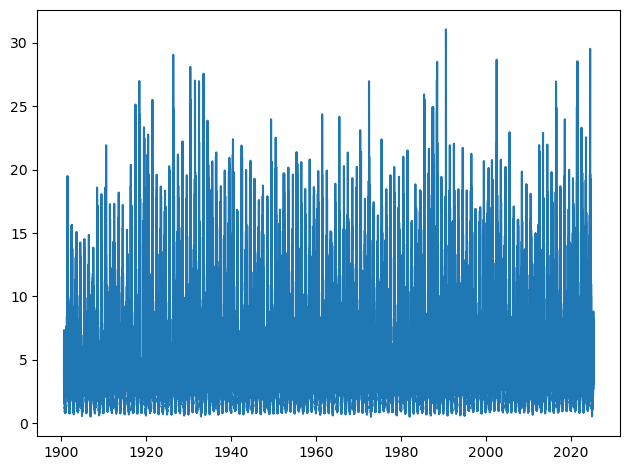

In [14]:
plt.plot(EPOT);

### Pastas Application

The stresses do not have a regular time step and therefore they need to be resampled with the help of Pandas

In [15]:
PRCP = PRCP.resample("24h", closed="right", label="right").mean()
EPOT = EPOT.resample("24h", closed="right", label="right").mean()

In [16]:
ps.validate_stress(EPOT)
ps.validate_stress(PRCP)

True

Now there are nan-values but those will be filled up with Pastas, so let's first create a basic pastas model

#### Basic Pastas Model

In [17]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    17                     EVP         0.00
nobs    1808                   R2         -0.00
noise   False                  RMSE        3.20
tmin    1987-01-10 00:00:00    AICc     4219.92
tmax    2024-10-25 00:00:00    BIC      4247.38
freq    D                      Obj      9277.10
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (5 optimized)
                optimal    initial  vary
rch_A          0.000010   0.175139  True
rch_n         67.710965   1.000000  True
rch_a       2551.831931  10.000000  True
rch_f         -1.999979  -1.000000  True
constant_d    -6.679243  -6.679223  True

Warnings! (1)
Response tmax for 'rch' > than calibration period.


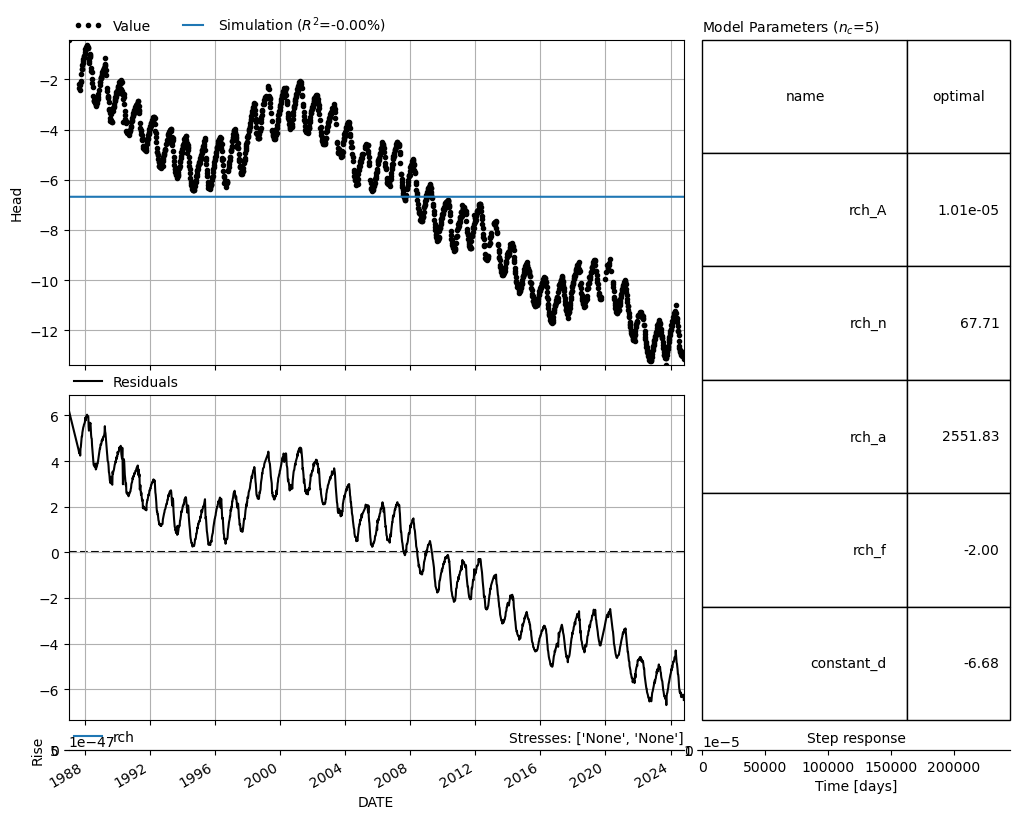

In [18]:
ml.plots.results();

#### Resample Monthly

In [19]:
head_resampled = head.resample('M').first()

In [20]:
head_resampled

Date and Time
1987-01-31    -0.423672
1987-02-28          NaN
1987-03-31          NaN
1987-04-30          NaN
1987-05-31          NaN
                ...    
2024-06-30   -11.814048
2024-07-31   -12.423648
2024-08-31   -12.780264
2024-09-30   -13.021056
2024-10-31   -12.911328
Freq: M, Name: Value, Length: 454, dtype: float64

In [21]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 11 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    13                     EVP         0.00
nobs    443                    R2         -0.00
noise   False                  RMSE        3.20
tmin    1987-01-31 00:00:00    AICc     1040.85
tmax    2024-10-31 00:00:00    BIC      1061.18
freq    D                      Obj      2268.97
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (5 optimized)
             optimal    initial  vary
rch_A       0.000010   0.175139  True
rch_n       0.010000   1.000000  True
rch_a       0.023526  10.000000  True
rch_f      -2.000000  -1.000000  True
constant_d -6.653724  -6.653578  True

Warnings! (3)
Parameter 'rch_A' on lower bound: 1.00e-05
Parameter 'rch_n' on lower bound: 1.00e-02
Parameter 'rch_f' on lower bound: -2.00e+00


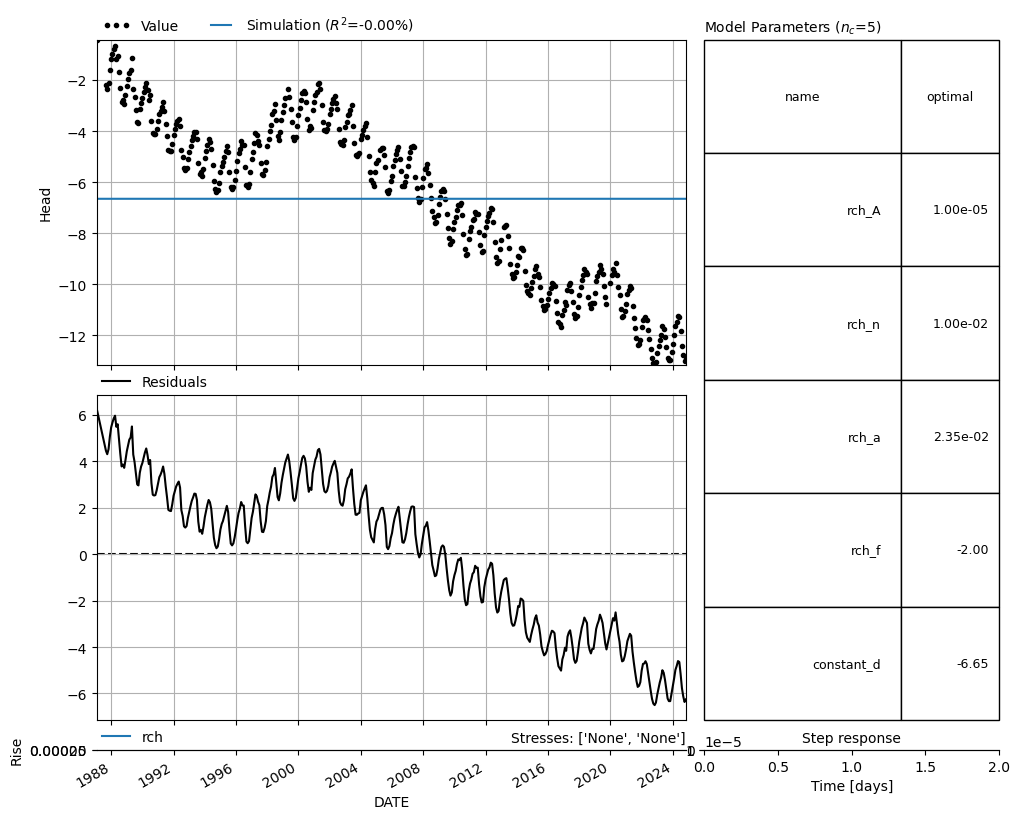

In [22]:
ml.plots.results();

### Try out different response functions and recharge models

In [23]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Spline(), name="rch", recharge=ps.rch.Peterson())
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 11 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    935                    EVP         3.13
nobs    443                    R2          0.03
noise   False                  RMSE        3.15
tmin    1987-01-31 00:00:00    AICc     1052.05
tmax    2024-10-31 00:00:00    BIC      1120.20
freq    D                      Obj      2197.88
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (17 optimized)
                 optimal   initial   vary
rch_A       1.209899e-01  1.214917   True
rch_1       1.000000e+00  0.090909   True
rch_2       6.223317e-02  0.181818   True
rch_4       9.885658e-01  0.272727   True
rch_8       5.667555e-01  0.363636   True
rch_16      6.401215e-01  0.454545   True
rch_32      2.528979e-01  0.545455   True
rch_64      5.154560e-01  0.636364   True
rch_128     2.870848e-14  0.727273   True
rch_256     1.000000e+00  0.818182   True
rch_512     2.465649e-07  0.909091   True
rch_1024    1.000000e+00  1.000000  F

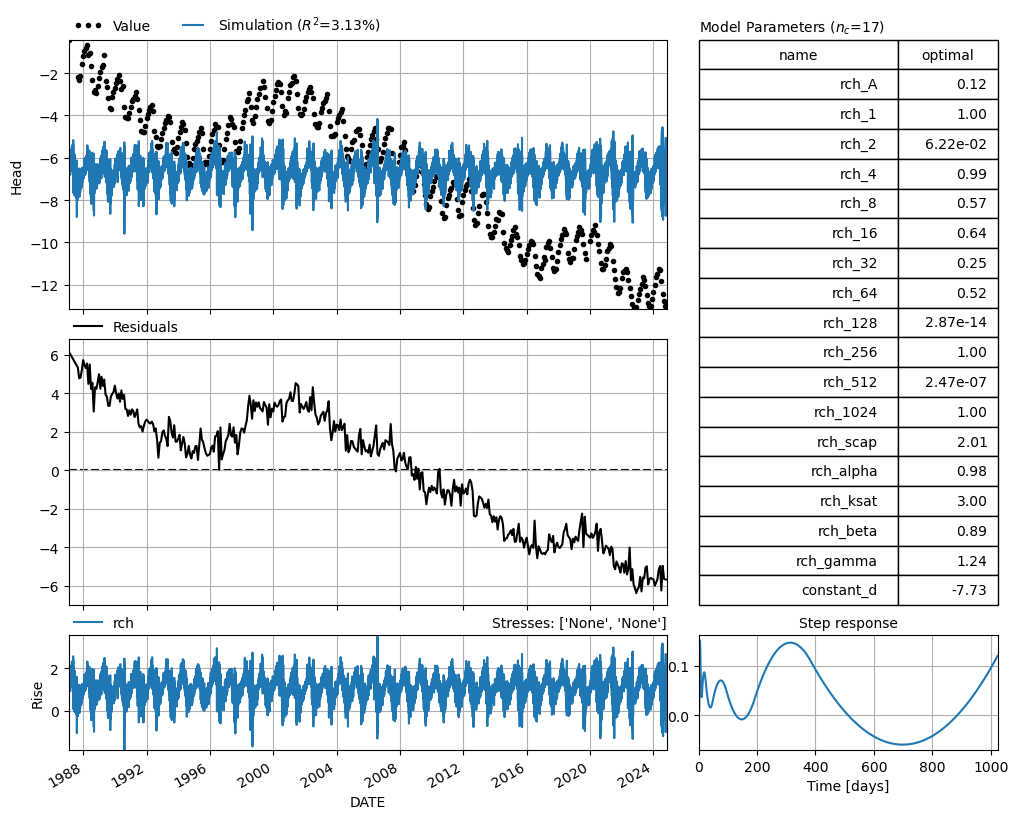

In [24]:
ml.plots.results();

In [25]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Peterson())
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 11 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    418                    EVP         1.20
nobs    443                    R2          0.01
noise   False                  RMSE        3.18
tmin    1987-01-31 00:00:00    AICc     1043.77
tmax    2024-10-31 00:00:00    BIC      1080.20
freq    D                      Obj      2241.72
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (9 optimized)
              optimal    initial  vary
rch_A        2.595308   1.214917  True
rch_n        0.170021   1.000000  True
rch_a       14.416792  10.000000  True
rch_scap     1.515842   1.500000  True
rch_alpha    0.592955   1.000000  True
rch_ksat     0.205389   1.000000  True
rch_beta     0.204585   0.500000  True
rch_gamma    1.068994   1.000000  True
constant_d -10.239691  -6.653578  True


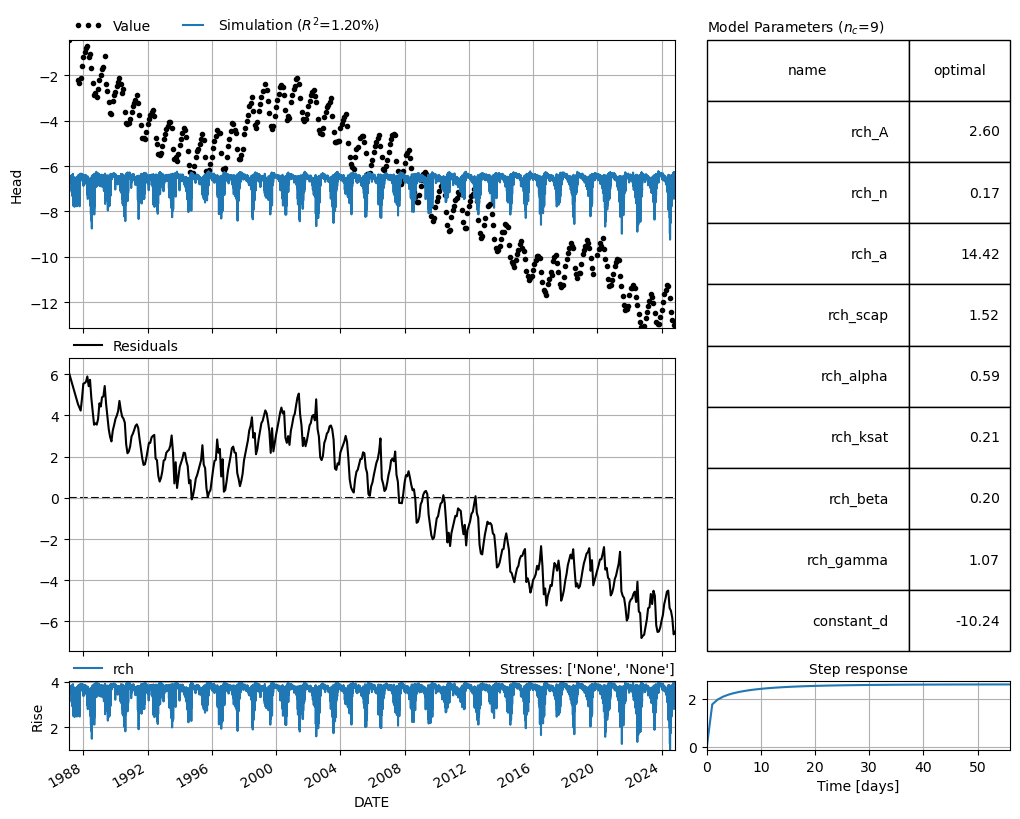

In [26]:
ml.plots.results();

#### Add trends

In [48]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Peterson())
ml.add_stressmodel(sm)

tm1 = ps.LinearTrend(start="1988-01-01", end="1995-01-01", name="trend1")
ml.add_stressmodel(tm1)
tm2 = ps.LinearTrend(start='1995-01-01', end='2002-01-01', name='trend2')
ml.add_stressmodel(tm2)
tm3 = ps.LinearTrend(start='2002-01-01', end='2017-01-01', name='trend3')
ml.add_stressmodel(tm3)
tm4 = ps.LinearTrend(start='2017-01-01', end='2020-01-01', name='trend4')
ml.add_stressmodel(tm4)
tm5 = ps.LinearTrend(start='2020-01-01', end='2024-01-01', name='trend5')
ml.add_stressmodel(tm5)

ml.solve()

INFO: Time Series 'Value': 11 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 86 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'None': 87 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                    Fit Statistics
nfev    37                     EVP           98.91
nobs    443                    R2             0.99
noise   False                  RMSE           0.33
tmin    1987-01-31 00:00:00    AICc        -940.40
tmax    2024-10-31 00:00:00    BIC         -884.07
freq    D                      Obj           24.83
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (14 optimized)
                     optimal        initial   vary
rch_A              10.229351       1.214917   True
rch_n               1.290345       1.000000   True
rch_a             152.638256      10.000000   True
rch_scap            1.049881       1.500000   True
rch_alpha           0.818654       1.000000   True
rch_ksat            0.285708       1.000000   True
rch_beta            0.108517       0.500000   True
rch_gamma           0.002354       1.000000   True
trend1_a           -0.001718       0.000000   True
tren

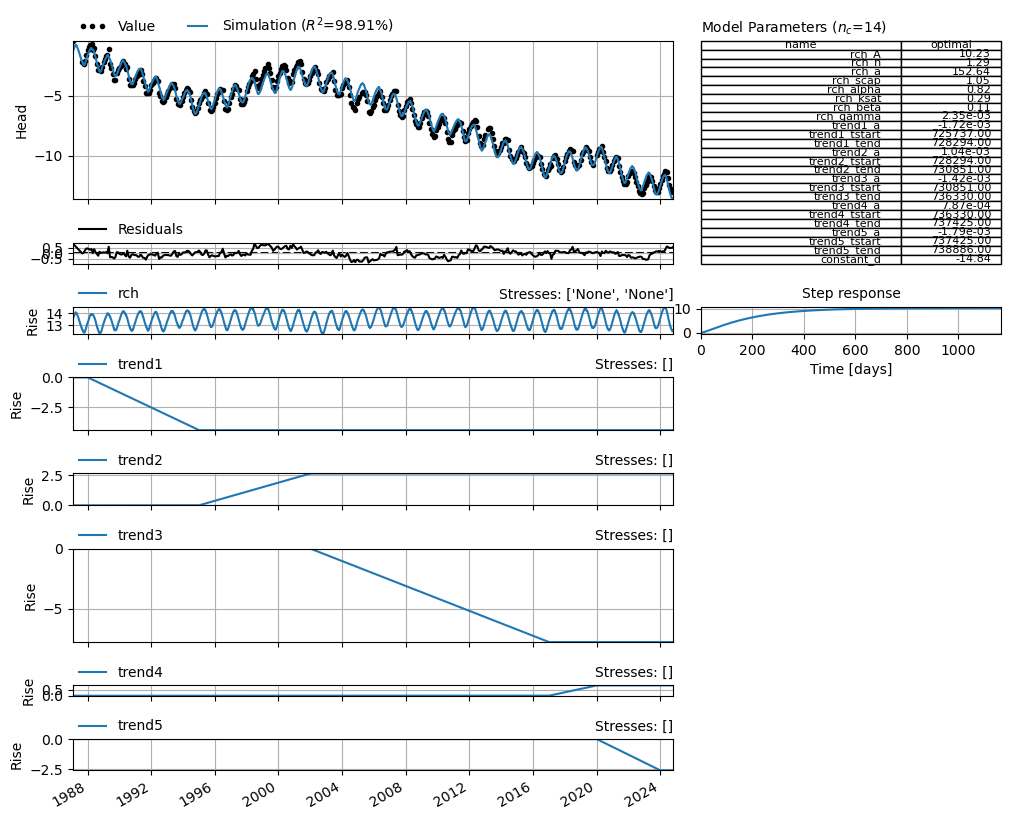

In [49]:
ml.plots.results();